# Softmax regression for phenotype cluster membership prediction

Author: Rachael Caelie "Rocky" Aikens 

Created: Oct 23, 2017

Version: 3

This document describes a rough pipeline for predicting phenotype clustering from genotype.

In [11]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random

## Data preprocessing

We have genotype information for siblings from the Agre and Simons Simplex Collection, which has been featurized into a binary matrix (described below). In addition to that, we have imputed ASD/non-ASD labels and ADOS/ADI-R scores for a subset of those individuals.

### Feature Data (Genotype)

The input data is represented as a binary matrix.  There are a couple different representations we can use here, but to start I will use 1 = loss of function variant(compound het or homozygous alternate), 0 = no loss of function variant.

In [12]:
# load input feature dataset for Agre
Agre_asd = pd.read_csv("data/v34_lof_asd_af0.50.txt", index_col=0).transpose()
Agre_ctrl = pd.read_csv("data/v34_lof_typical_af0.50.txt", index_col=0).transpose()

print "Cases: ", Agre_asd.shape[0]
print "Controls: ", Agre_ctrl.shape[0]

Cases:  1616
Controls:  349


In [13]:
# load input feature dataset for SSC
SSC_asd = pd.read_csv("data/SSC_lof_asd_af0.50.txt", index_col=0).transpose()
SSC_ctrl = pd.read_csv("data/SSC_lof_typical_af0.50.txt", index_col=0).transpose()

print "Cases: ", SSC_asd.shape[0]
print "Controls: ", SSC_ctrl.shape[0]

Cases:  517
Controls:  518


In [14]:
# merge SSC and Agre data
X_asd = pd.concat([SSC_asd, Agre_asd], axis = 0).fillna(0)
X_ctrl = pd.concat([SSC_ctrl, Agre_ctrl], axis = 0).fillna(0)

In [15]:
X = pd.concat([X_asd, X_ctrl], axis=0)
print "Total cases: ", X_asd.shape[0]
print "Total controls: ", X_ctrl.shape[0]
print "Features (ie. genes): ", X.shape[1]
print "Missing Values: ", int(X.isnull().values.any())

Total cases:  2133
Total controls:  867
Features (ie. genes):  1109
Missing Values:  0


### Target Data (Phenotype Cluster)

We have soft k means cluster membership information for an overlapping set of individuals, for varying values of k.  We will start with k = 3, since this was the focus of Kelley's paper. 

In [1]:
# load outcome dataset
Y_soft_3 = pd.read_csv("/scratch/PI/dpwall/DATA/iHART/kpaskov/PhenotypeGLRM/data/softkmeans_logloss_X3.csv", index_col=0, header = None)

NameError: name 'pd' is not defined

#### Getting hard cluster definitions

For softmax regression to work, we need hard rather than soft labels for our dataset. We will turn our soft clustering into a hard one by assigning each subject to the cluster with the highest associated membership value.

In [17]:
Y_3 = Y_soft_3.idxmax(axis = 1)
print Y_3.value_counts()

3    6235
1    4875
2    2324
dtype: int64


### Filtering for Overlap
Once we import the data, we need to reconstruct X and Y so that they contain the same subjects in the same order.

In [18]:
# get lists of individuals in X and Y
m_x = X.index.values.tolist()
m_x_asd = X_asd.index.tolist()
m_x_ctrl = X_ctrl.index.tolist()
m_y = Y_3.index.values.tolist()

# check subject overlap between X and Y
print "%d subjects in X are not in y.  Of these, %d are cases and %d are controls." % (len(set(m_x) - set(m_y)), len(set(m_x_asd) - set(m_y)), len(set(m_x_ctrl) - set(m_y)))

# make a list of Subject IDs with overlap
subjects = list(set(m_x) & set(m_y))
print "This leaves %d subjects: %d cases and %d controls." % (len(subjects), len(set(m_x_asd) & set(m_y)), len(set(m_x_ctrl)&set(m_y))) 

868 subjects in X are not in y.  Of these, 5 are cases and 863 are controls.
This leaves 2132 subjects: 2128 cases and 4 controls.


**Note:** The set of "cases" and "controls" appear to be differently defined between the iHart Phenotype labels (see `LR_CGT_to_diagnosis.ipynb`) and the CGT matrix labels. 

In [19]:
# redefine X and Y to contain only individuals with genotype and phenotype data
X = X.ix[subjects]
Y_3 = Y_3.ix[subjects]

# check we have the same subject IDs in the same order for X and Y
print Y_3.index.values.tolist() == X.index.values.tolist()

True


## Hold-out Test Set

Since we have ~1,600 examples, I'm going to hold out 20% of the data as a test set and then do 5 fold cross validation using built-in sklearn methods.

In [20]:
random.seed(143)
X_train, X_test, y_train, y_test = train_test_split(X, Y_3, test_size=0.2)

## Basic Regression Model: Softmax

I am going to implement softmax (aka multinomial logistic) regression using sklearn.

We'll start with the following parameters:
- Penalty distance metric = $L_2$
- Dual formulation = `False` (better when $m$ > $n$)
- tolerance for convergence = $1\times 10^{-4}$
- c ($\frac{1}{\lambda}$ for regularization) = 1
- fit_intercept = `True`
- class weighting = None
- optimization algorithm = Newton's Method
- multi_class = 'multinomial'

The scoring function I will use is `accuracy_score`, which just gives the percent of examples which are correctly classified.


In [21]:
# Import EvalLR
import class_EvalLR
reload(class_EvalLR)
from class_EvalLR import EvalLR

In [22]:
evalr = EvalLR(X_train, y_train, multi_class = 'multinomial', solver = 'newton-cg', c = 1)


Running cross validation for fold 1:
Train Score: 0.776930 Test Score: 0.373206


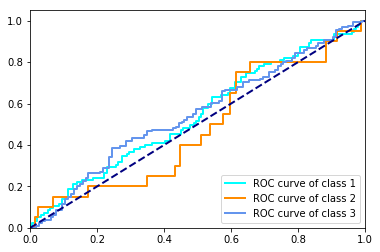


Running cross validation for fold 2:
Train Score: 0.776763 Test Score: 0.314721


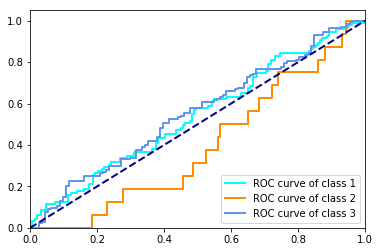


Running cross validation for fold 3:
Train Score: 0.798347 Test Score: 0.259615


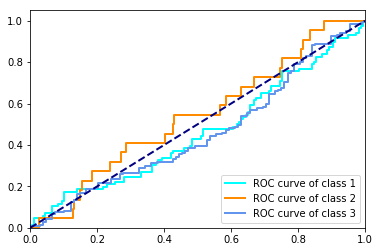


Running cross validation for fold 4:
Train Score: 0.785953 Test Score: 0.328767


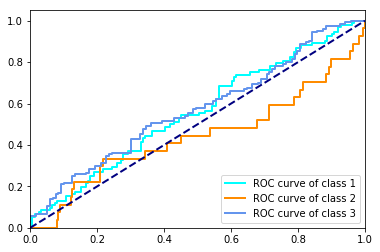


Running cross validation for fold 5:
Train Score: 0.780922 Test Score: 0.336957


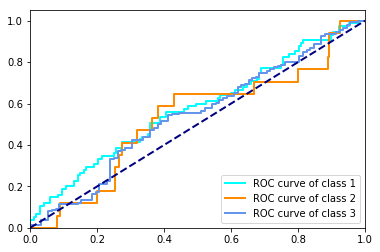


Running cross validation for fold 6:
Train Score: 0.798319 Test Score: 0.417062


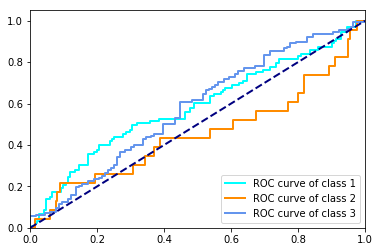


Running cross validation for fold 7:
Train Score: 0.800651 Test Score: 0.404145


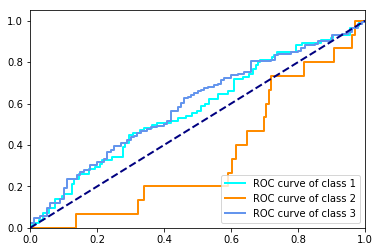

In [23]:
scores, topgenes = evalr.kfold(7, makeROC = True)

In [24]:
print scores
print "Train:", np.mean(scores.Train_score)
print "Test:", np.mean(scores.Test_score)

  Train_score Test_score
1     0.77693   0.373206
2    0.776763   0.314721
3    0.798347   0.259615
4    0.785953   0.328767
5    0.780922   0.336957
6    0.798319   0.417062
7    0.800651   0.404145
Train: 0.788269317066
Test: 0.347781753221


# Regularization

One way to address our overfit problem is to increase the regularization parameter, $C$.  I've written a function below, `reg_plot`, which performs 5 fold cross validation for models with different values of $C$.  

**Note** Recall that $C$ is the inverse of the cannonical regularization parameter, $\lambda$, so that smaller $C$ corresponds to stronger regularization.

In [25]:
# setting a seed here so that the content is the same whenever I compile
np.random.seed(144)

In [26]:
# could implement this as wrapper for EvalLR if that ends up making sense
def reg_plot(c_vals, X_train, y_train):
    c_scores = []
    for i in range(len(c_vals)):
        evalr = EvalLR(X_train, y_train, multi_class = 'multinomial', solver = 'newton-cg', c = c_vals[i] )
        c_scores.append(np.mean(evalr.kfold(7, False, False)[0].Test_score))

    plt.clf()
    plt.ylabel('Feature 2')
    plt.xlabel('Feature 1')
    plt.plot(c_vals, c_scores, linestyle = '-')
    plt.show()
    plt.figure(figsize=(10,10))

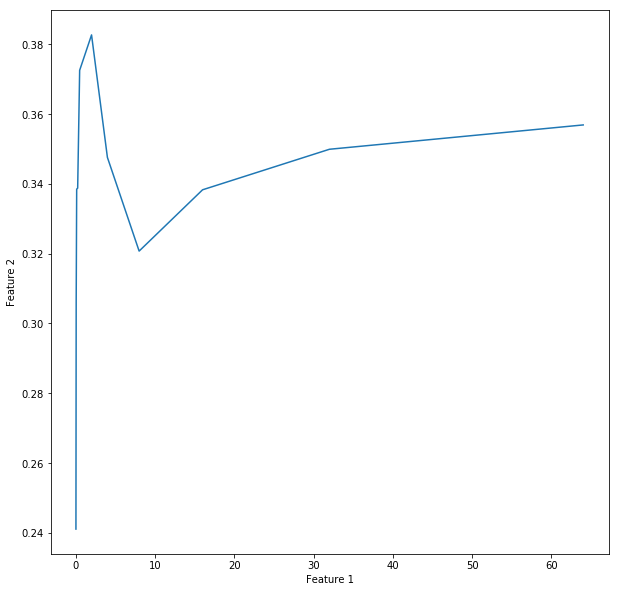

In [27]:
c_vals = [2**6, 2**5, 2**4, 2**3, 2**2, 2, 2**-1, 2**-2, 2**-3, 2**-4, 2**-5]
reg_plot(c_vals, X_train, y_train)

One issue with this approach is that random chance affects our mean test score extensively, so different runs of `reg_plot` will produce different peaks and troughs in the regularization parameter performance.  However, there does seem to be a consistent peak in performance between C = 0 and C = 15.  We can zoom in on that peak by testing more values along that region.

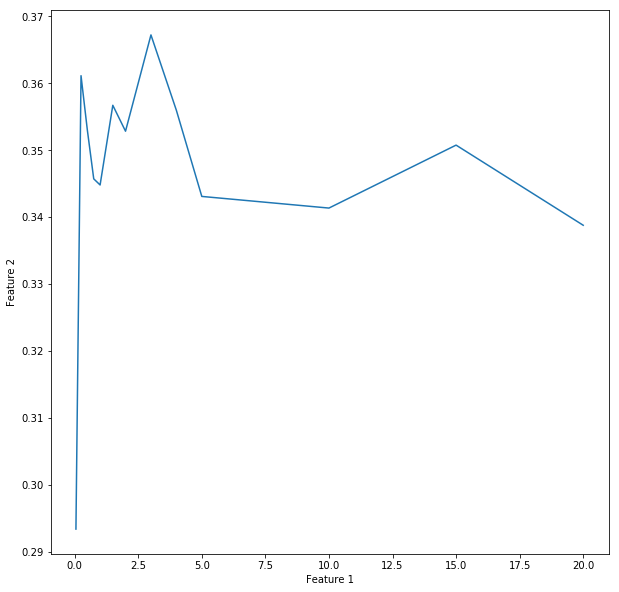

In [28]:
c_vals = [0.05, 0.25, 0.5, 0.75, 1, 1.5, 2, 3, 4, 5, 10, 15, 20]
reg_plot(c_vals, X_train, y_train)

Now let's train and evaluate our classifier again with a c value along that peak.

In [29]:
evalr = EvalLR(X_train, y_train, multi_class = 'multinomial', solver = 'newton-cg', c = 2)


Running cross validation for fold 1:
Train Score: 0.842688 Test Score: 0.287129


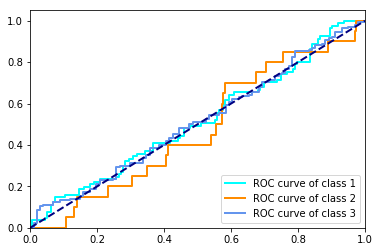


Running cross validation for fold 2:
Train Score: 0.848039 Test Score: 0.321101


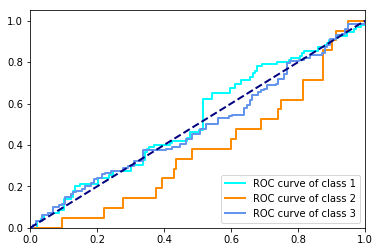


Running cross validation for fold 3:
Train Score: 0.846032 Test Score: 0.356808


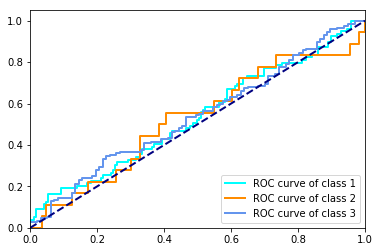


Running cross validation for fold 4:
Train Score: 0.846216 Test Score: 0.377358


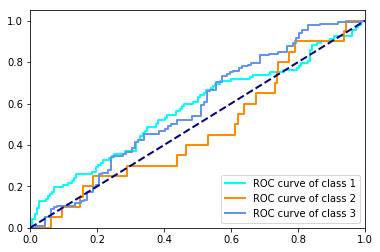


Running cross validation for fold 5:
Train Score: 0.824402 Test Score: 0.423963


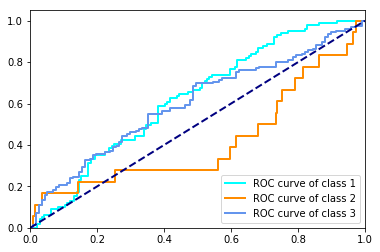


Running cross validation for fold 6:
Train Score: 0.846656 Test Score: 0.356808


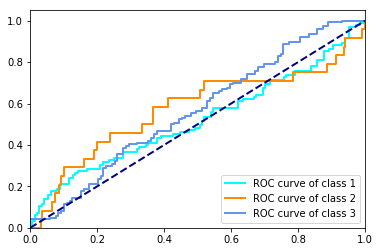


Running cross validation for fold 7:
Train Score: 0.839585 Test Score: 0.343750


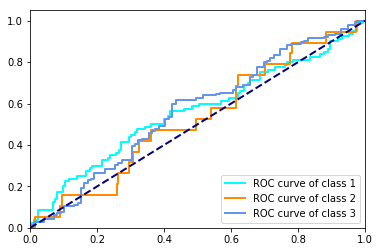

AttributeError: 'tuple' object has no attribute 'mean'

In [30]:
evalr.kfold(7, makeROC = True).mean(axis= 0)

# Improvements

Right now we have an overfit problem.  We can fix this in two ways:

- tinkering with the regularization parameter
- attempting to use a different regression method (e.g. lasso)
- l1 regularization

Other improvements:
- Perform initial split of train and test data by family